In [1]:
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
import os
import seaborn as sns
import sys
sys.path.append("../")
import time
import warnings
warnings.simplefilter("ignore")
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer, average_precision_score, precision_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [2]:
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats
import warnings
from colorama import Fore, Back, Style
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [3]:
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import plot_missing_proportion_barchart, get_cols
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, FILLNA_COLUMNS, HAS_VALUE_COLUMNS, BINARY_COLUMNS, CONTINUOUS_COLUMNS, 
    SPECIAL_COLUMNS, ROUND_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, CONFIRM_DROP_FEATURES
)

In [4]:
DATA_PATH = "../raw_data"
os.listdir(DATA_PATH)

['train_labels.csv',
 '.DS_Store',
 'train_post_format.pkl copy',
 'test_post_format.pkl',
 'train_lag0_post_format.pkl',
 'train_post_format.pkl',
 'train_lag0_pre_format.pkl',
 '.ipynb_checkpoints',
 'test_parquet',
 'train_parquet',
 'sample_submission.csv',
 'test_post_format.pkl copy']

In [5]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"

In [6]:
%load_ext autoreload
%autoreload

In [7]:
RAW_TRAIN_CSV_PATH = os.path.join(RAW_DATA_PATH, "train_csv")
RAW_TRAIN_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "train_parquet")
RAW_TRAIN_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "train_pickle")
RAW_TRAIN_FEATHER_PATH = os.path.join(RAW_DATA_PATH, "train_ftr")
RAW_TEST_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "test_parquet")
RAW_TEST_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "test_pickle")

### Read Data

In [8]:
# id_mapping_df = pd.read_csv(f"{PROCESSED_DATA_PATH}/id_mapping_df.csv")

In [9]:
%%time
# df = read_file(f"{RAW_TRAIN_PARQUET_PATH}/train_data.parquet")
# df = read_file(f"{RAW_TEST_PARQUET_PATH}/test_data.parquet")
# test = read_file(f"{RAW_DATA_PATH}/test_post_format.pkl")
df = read_file(f"{RAW_DATA_PATH}/train_post_format.pkl")

Shape of data: (5531451, 191)
CPU times: user 4.53 s, sys: 3.03 s, total: 7.55 s
Wall time: 7.56 s


In [10]:
# for col in test.columns:
#     if test[col].dtype != train[col].dtype:
#         print(col)

In [11]:
df.dtypes.value_counts()

float32           107
float16            34
int8               34
int64               3
category            3
object              1
datetime64[ns]      1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
dtype: int64

In [12]:
# test.dtypes.value_counts()

In [13]:
# train.to_pickle(f"{RAW_DATA_PATH}/train_post_format.pkl")

In [14]:
# test.to_pickle(f"{RAW_DATA_PATH}/test_post_format.pkl")

In [15]:
# df["customer_ID"] = df["customer_ID"].astype(str)
# df["S_2"] = df["S_2"].dt.date

In [16]:
if "row_number" not in df.columns:
    df.insert(1, "row_number", df.groupby("customer_ID")["S_2"].rank(method="first", ascending=False).astype(int))

In [17]:
# df.dtypes.value_counts()

In [18]:
for column in tqdm(BINARY_COLUMNS):
    if df[column].dtype != "float16":
        df[column] = df[column].round().astype("float16")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 20.60it/s]


In [19]:
for column, multiplier in tqdm(ROUND_COLUMNS.items()):
    if df[column].dtype != "float16":
        df[column] = df[column] * multiplier
        df[column] = df[column].round()
        df[column] += abs(df[column].min())
        df[column] = df[column].astype("float16")
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 39.65it/s]


In [20]:
for column in tqdm(CATEGORY_COLUMNS):
    if df[column].dtype != "category":
        df[column] = df[column].astype("category")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 19223.89it/s]


In [21]:
for column, fillna_value in tqdm(FILLNA_COLUMNS.items()):
    df[column] = df[column].fillna(fillna_value)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


In [22]:
for column in tqdm(HAS_VALUE_COLUMNS):
    if df[column].isnull().sum() > 0:
        df[column] = (~df[column].isnull()).astype(int)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 168.81it/s]


In [23]:
for column in tqdm(list(ROUND_COLUMNS.keys()) + BINARY_COLUMNS):
    missing_proportion = df[column].isnull().sum() / df.shape[0]
    if missing_proportion == 0:
        df[column] = df[column].astype("int8")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 45.94it/s]


In [24]:
df.head()

,customer_ID,row_number,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,13,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,...,1,NaN,0.0,0.0,0.003818,NaN,0.0,0.000610,0.0,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,12,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,...,1,NaN,0.0,0.0,0.005032,NaN,0.0,0.005492,0.0,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,11,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,...,1,NaN,0.0,0.0,0.000427,NaN,0.0,0.006986,0.0,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,10,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,...,1,NaN,0.0,0.0,0.003200,NaN,0.0,0.006527,0.0,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,9,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,...,1,NaN,0.0,0.0,0.008889,NaN,0.0,0.008126,0.0,0


B_18
Data size: (5531451, 191)
Missing proportion: 0.00


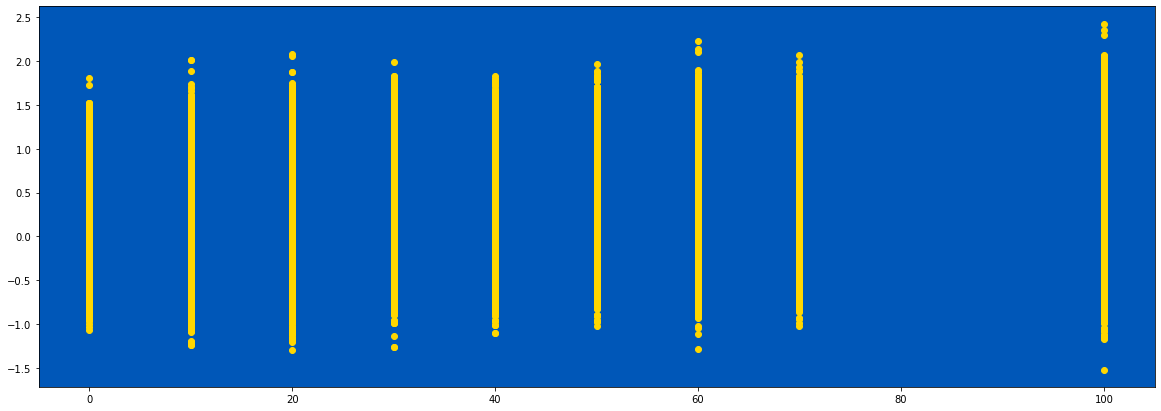

B_22
Data size: (5531451, 191)
Missing proportion: 0.00


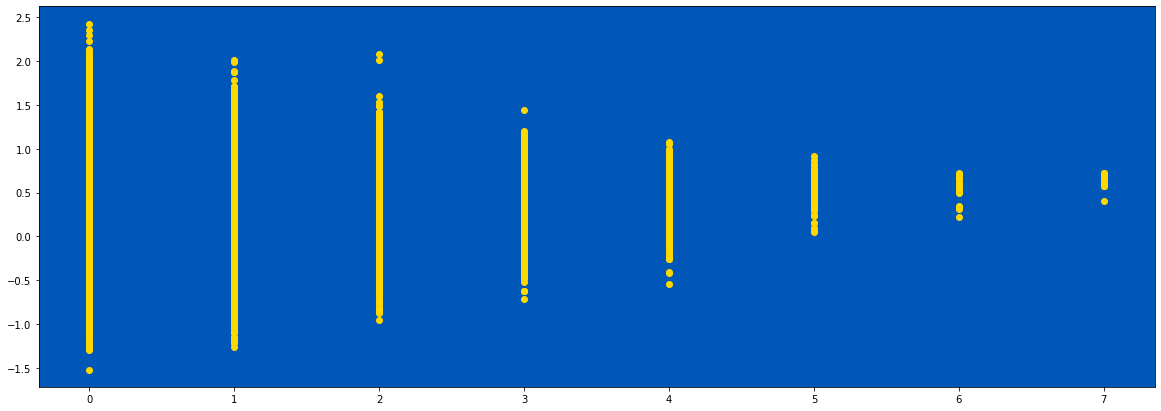

B_41
Data size: (5531451, 191)
Missing proportion: 0.00



KeyboardInterrupt



In [25]:
for column in ROUND_COLUMNS:
    print(column)
    print("Data size:", df.shape)
    print(f"Missing proportion: {df[column].isnull().sum() / df.shape[0]:.2f}")
    plt.figure(figsize=(20, 7))
    plt.scatter(x=df[column], y=df["P_3"])
    plt.show()

In [ ]:
def process_data_type_and_format(df):
    for cat_col in CATEGORY_COLUMNS:
        if df.loc[:, cat_col].dtype != "category":
            df.loc[:, cat_col] = df.loc[:, cat_col].astype("category")

    for col in INTEGER_COLUMNS:
        try:
            df.loc[:, col] = df.loc[:, col].astype("int8")
        except:
            df.loc[:, col] = df.loc[:, col].round(0)

    for col in HAS_VALUE_COLUMNS:
        df.loc[:, col] = (~df.loc[:, col].isnull()).astype("int8")

    for col in BINARY_COLUMNS:
        try:
            df.loc[:, col] = df.loc[:, col].astype("int8")
        except:
            df.loc[:, col] = df.loc[:, col].round(0)

    for col in FILLNA_COLUMNS:
        df.loc[:, col] = df.loc[:, col].fillna(0).astype("int8")
        
    return df

In [ ]:
%%time
df = process_data_type_and_format(df)

In [ ]:
# df.to_pickle(f"{RAW_DATA_PATH}/te_post_format.pkl")

### END

In [26]:
%%time
df_lag0 = df.loc[df["row_number"] == 1].reset_index(drop=True)

CPU times: user 2.24 s, sys: 1.4 s, total: 3.64 s
Wall time: 3.64 s


In [27]:
# del train, val

In [28]:
labels_df = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")

In [29]:
# labels_df = labels_df.merge(id_mapping_df, 
#                             on="customer_ID", 
#                             how="left").drop(columns="customer_ID").rename(columns={"id": "customer_ID"})

In [30]:
# df_lag0 = df_lag0.merge(
#     labels_df, 
#     on="customer_ID", 
#     how="left"
# )

In [31]:
settle_columns = sorted(
    CATEGORY_COLUMNS + HAS_VALUE_COLUMNS + SPECIAL_COLUMNS + BINARY_COLUMNS + CONTINUOUS_COLUMNS + \
    list(FILLNA_COLUMNS) + list(ROUND_COLUMNS.keys())
)

In [32]:
# %%time
# df_lag0.loc[:, CATEGORY_COLUMNS] = df_lag0.loc[:, CATEGORY_COLUMNS].astype("category")

# for col in HAS_VALUE_COLUMNS:
#     df_lag0.loc[:, col] = (~df_lag0.loc[:, col].isnull()).astype("int8")

# for col in BINARY_COLUMNS:
#     try:
#         df_lag0.loc[:, col] = df_lag0.loc[:, col].astype("int8")
#     except:
#         df_lag0.loc[:, col] = df_lag0.loc[:, col].round(0)

# for col in FILLNA_COLUMNS:
#     df_lag0.loc[:, col] = df_lag0.loc[:, col].fillna(0).astype("int8")

In [33]:
# df_lag0.to_pickle(f"{RAW_DATA_PATH}/train_lag0_post_format.pkl")

In [34]:
belum_settle_columns = sorted([col for col in df_lag0.columns[3:-1] if col not in settle_columns])
print(belum_settle_columns)

[]


In [35]:
# index = 31
# column = belum_settle_columns[index]
# print(column)
# print("Data size:", df_lag0.shape)
# print("Missing value:", df_lag0[column].isnull().sum())
# plt.figure(figsize=(20, 7))
# plt.scatter(x=df_lag0[column], y=df_lag0["P_3"])
# plt.show()

In [36]:
df_lag0[column].round(1).describe()

count    458913.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max          22.0
Name: B_41, dtype: float64

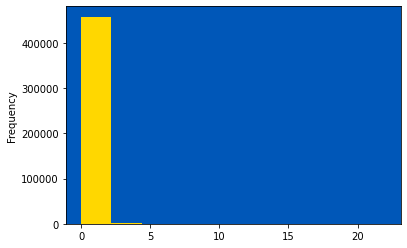

In [37]:
df_lag0[column].plot.hist()
plt.show()

### Dart Training

In [38]:
train, val = train_test_split(df_lag0, test_size=0.15, random_state=923, stratify=df_lag0["target"])

In [39]:
train.shape, val.shape

((390076, 191), (68837, 191))

In [40]:
target = train["target"].values

In [41]:
features = [col for col in train.columns if col not in ["customer_ID", "row_number", "S_2", "target"]]

In [51]:
def objective(trial):
    kf = StratifiedKFold(n_splits=5)
    params = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "dart",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 3, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 3, log=True),
        # "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 280, 360),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.65),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),
        "subsample_freq": trial.suggest_int("subsample_freq", 3, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 150, 225),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.9, 2.25),
        # "max_bins": trial.suggest_int("max_bins", 100, 200),
        # "max_depth": trial.suggest_int("max_depth", 10, 20),
    }
    
    score_list = []
    params["learning_rate"] = 0.05
    params["num_leaves"] = 100000
    print(params)
    for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(train, target)):
        X_train, X_val, y_train, y_val, model = None, None, None, None, None
        X_train = train.iloc[idx_tr][features]
        X_val = train.iloc[idx_va][features]
        y_train = target[idx_tr]
        y_val = target[idx_va]
        model = LGBMClassifier(**params)
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=UserWarning)
            model.fit(
                X_train,
                y_train,
                eval_set=[(X_val, y_val)], 
                eval_metric=[lgb_amex_metric],
                verbose=-1
                # callbacks=[log_evaluation(params["n_estimators"])]
            )
        y_train_pred = model.predict_proba(X_train, raw_score=True)
        train_score = amex_metric(y_train, y_train_pred)
        X_train, y_train = None, None
        y_val_pred = model.predict_proba(X_val, raw_score=True)
        val_score = amex_metric(y_val, y_val_pred)
        print(f"Fold {fold} | Train Score = {train_score:.5f}")
        print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val   Score = {val_score:.5f}{Style.RESET_ALL}")
        score_list.append(val_score)

    return np.mean(score_list)

In [52]:
# study = optuna.create_study(direction="maximize")

In [53]:
study.optimize(objective, n_trials=30)

{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.05221046187839167, 'reg_lambda': 0.05529458963492882, 'n_estimators': 295, 'colsample_bytree': 0.32282318425268186, 'subsample': 0.5469636131652487, 'subsample_freq': 5, 'min_child_samples': 193, 'scale_pos_weight': 2.0818498921083166, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.84480
Fold 1 | Val   Score = 0.78127
Fold 2 | Train Score = 0.84513
Fold 2 | Val   Score = 0.77877
Fold 3 | Train Score = 0.84369
Fold 3 | Val   Score = 0.78488
Fold 4 | Train Score = 0.84485
Fold 4 | Val   Score = 0.78013


[I 2022-07-09 09:51:50,423] Trial 30 finished with value: 0.7800692946733639 and parameters: {'reg_alpha': 0.05221046187839167, 'reg_lambda': 0.05529458963492882, 'n_estimators': 295, 'colsample_bytree': 0.32282318425268186, 'subsample': 0.5469636131652487, 'subsample_freq': 5, 'min_child_samples': 193, 'scale_pos_weight': 2.0818498921083166}. Best is trial 26 with value: 0.781032892376459.


Fold 5 | Train Score = 0.84592
Fold 5 | Val   Score = 0.77529
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.07047595415756429, 'reg_lambda': 0.0826101286266779, 'n_estimators': 289, 'colsample_bytree': 0.6374817483035293, 'subsample': 0.8338623453678681, 'subsample_freq': 5, 'min_child_samples': 193, 'scale_pos_weight': 2.1495696266726605, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.88170
Fold 1 | Val   Score = 0.78232
Fold 2 | Train Score = 0.88169
Fold 2 | Val   Score = 0.77886
Fold 3 | Train Score = 0.88222
Fold 3 | Val   Score = 0.78302
Fold 4 | Train Score = 0.88142
Fold 4 | Val   Score = 0.77966


[I 2022-07-09 10:04:44,969] Trial 31 finished with value: 0.7797626884434999 and parameters: {'reg_alpha': 0.07047595415756429, 'reg_lambda': 0.0826101286266779, 'n_estimators': 289, 'colsample_bytree': 0.6374817483035293, 'subsample': 0.8338623453678681, 'subsample_freq': 5, 'min_child_samples': 193, 'scale_pos_weight': 2.1495696266726605}. Best is trial 26 with value: 0.781032892376459.


Fold 5 | Train Score = 0.88285
Fold 5 | Val   Score = 0.77495
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.029133121110540693, 'reg_lambda': 0.018254895262542932, 'n_estimators': 294, 'colsample_bytree': 0.4568954487318736, 'subsample': 0.8236590924765501, 'subsample_freq': 5, 'min_child_samples': 180, 'scale_pos_weight': 2.1409626120863003, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.88586
Fold 1 | Val   Score = 0.78091
Fold 2 | Train Score = 0.88492
Fold 2 | Val   Score = 0.77956
Fold 3 | Train Score = 0.88514
Fold 3 | Val   Score = 0.78577
Fold 4 | Train Score = 0.88475
Fold 4 | Val   Score = 0.78088


[I 2022-07-09 10:17:01,291] Trial 32 finished with value: 0.780356664126467 and parameters: {'reg_alpha': 0.029133121110540693, 'reg_lambda': 0.018254895262542932, 'n_estimators': 294, 'colsample_bytree': 0.4568954487318736, 'subsample': 0.8236590924765501, 'subsample_freq': 5, 'min_child_samples': 180, 'scale_pos_weight': 2.1409626120863003}. Best is trial 26 with value: 0.781032892376459.


Fold 5 | Train Score = 0.88682
Fold 5 | Val   Score = 0.77466
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.011809819957965323, 'reg_lambda': 0.08940773758339725, 'n_estimators': 288, 'colsample_bytree': 0.5442166869937386, 'subsample': 0.5077037030770382, 'subsample_freq': 5, 'min_child_samples': 198, 'scale_pos_weight': 2.0589137358558656, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.84227
Fold 1 | Val   Score = 0.78263
Fold 2 | Train Score = 0.84235
Fold 2 | Val   Score = 0.77913
Fold 3 | Train Score = 0.84284
Fold 3 | Val   Score = 0.78653
Fold 4 | Train Score = 0.84264
Fold 4 | Val   Score = 0.78019


[I 2022-07-09 10:26:44,481] Trial 33 finished with value: 0.780484593226733 and parameters: {'reg_alpha': 0.011809819957965323, 'reg_lambda': 0.08940773758339725, 'n_estimators': 288, 'colsample_bytree': 0.5442166869937386, 'subsample': 0.5077037030770382, 'subsample_freq': 5, 'min_child_samples': 198, 'scale_pos_weight': 2.0589137358558656}. Best is trial 26 with value: 0.781032892376459.


Fold 5 | Train Score = 0.84332
Fold 5 | Val   Score = 0.77395
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.07490651257805736, 'reg_lambda': 0.04203180233535071, 'n_estimators': 295, 'colsample_bytree': 0.5020395707649, 'subsample': 0.8638274860000448, 'subsample_freq': 6, 'min_child_samples': 205, 'scale_pos_weight': 2.094718226282311, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.87928
Fold 1 | Val   Score = 0.78267
Fold 2 | Train Score = 0.87934
Fold 2 | Val   Score = 0.78051
Fold 3 | Train Score = 0.87843
Fold 3 | Val   Score = 0.78652
Fold 4 | Train Score = 0.87899
Fold 4 | Val   Score = 0.78105


[I 2022-07-09 10:39:07,485] Trial 34 finished with value: 0.7811815107570494 and parameters: {'reg_alpha': 0.07490651257805736, 'reg_lambda': 0.04203180233535071, 'n_estimators': 295, 'colsample_bytree': 0.5020395707649, 'subsample': 0.8638274860000448, 'subsample_freq': 6, 'min_child_samples': 205, 'scale_pos_weight': 2.094718226282311}. Best is trial 34 with value: 0.7811815107570494.


Fold 5 | Train Score = 0.88032
Fold 5 | Val   Score = 0.77516
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.04806928320505212, 'reg_lambda': 0.0486485045365051, 'n_estimators': 301, 'colsample_bytree': 0.5056740937370071, 'subsample': 0.8636400086026754, 'subsample_freq': 6, 'min_child_samples': 184, 'scale_pos_weight': 2.0939273928954347, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.89008
Fold 1 | Val   Score = 0.78365
Fold 2 | Train Score = 0.88949
Fold 2 | Val   Score = 0.77761
Fold 3 | Train Score = 0.89031
Fold 3 | Val   Score = 0.78517
Fold 4 | Train Score = 0.88993
Fold 4 | Val   Score = 0.78147


[I 2022-07-09 10:52:30,496] Trial 35 finished with value: 0.7805430126926398 and parameters: {'reg_alpha': 0.04806928320505212, 'reg_lambda': 0.0486485045365051, 'n_estimators': 301, 'colsample_bytree': 0.5056740937370071, 'subsample': 0.8636400086026754, 'subsample_freq': 6, 'min_child_samples': 184, 'scale_pos_weight': 2.0939273928954347}. Best is trial 34 with value: 0.7811815107570494.


Fold 5 | Train Score = 0.89116
Fold 5 | Val   Score = 0.77481
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.07616986538186112, 'reg_lambda': 0.024957054298278266, 'n_estimators': 303, 'colsample_bytree': 0.3062999735105544, 'subsample': 0.8932831079331761, 'subsample_freq': 4, 'min_child_samples': 194, 'scale_pos_weight': 2.0240994776116854, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.88106
Fold 1 | Val   Score = 0.78285
Fold 2 | Train Score = 0.88203
Fold 2 | Val   Score = 0.78103
Fold 3 | Train Score = 0.88211
Fold 3 | Val   Score = 0.78621
Fold 4 | Train Score = 0.88135
Fold 4 | Val   Score = 0.78058


[I 2022-07-09 11:04:30,009] Trial 36 finished with value: 0.7809456230822314 and parameters: {'reg_alpha': 0.07616986538186112, 'reg_lambda': 0.024957054298278266, 'n_estimators': 303, 'colsample_bytree': 0.3062999735105544, 'subsample': 0.8932831079331761, 'subsample_freq': 4, 'min_child_samples': 194, 'scale_pos_weight': 2.0240994776116854}. Best is trial 34 with value: 0.7811815107570494.


Fold 5 | Train Score = 0.88252
Fold 5 | Val   Score = 0.77407
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.023801701428866968, 'reg_lambda': 0.014197155528095789, 'n_estimators': 305, 'colsample_bytree': 0.30322241254931315, 'subsample': 0.896717566626187, 'subsample_freq': 4, 'min_child_samples': 191, 'scale_pos_weight': 2.0258602411842506, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.88314
Fold 1 | Val   Score = 0.78323
Fold 2 | Train Score = 0.88372
Fold 2 | Val   Score = 0.78149
Fold 3 | Train Score = 0.88267
Fold 3 | Val   Score = 0.78643
Fold 4 | Train Score = 0.88226
Fold 4 | Val   Score = 0.78086


[I 2022-07-09 11:17:03,598] Trial 37 finished with value: 0.7813677686265533 and parameters: {'reg_alpha': 0.023801701428866968, 'reg_lambda': 0.014197155528095789, 'n_estimators': 305, 'colsample_bytree': 0.30322241254931315, 'subsample': 0.896717566626187, 'subsample_freq': 4, 'min_child_samples': 191, 'scale_pos_weight': 2.0258602411842506}. Best is trial 37 with value: 0.7813677686265533.


Fold 5 | Train Score = 0.88339
Fold 5 | Val   Score = 0.77483
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.021569257530308354, 'reg_lambda': 0.012673749125498608, 'n_estimators': 304, 'colsample_bytree': 0.3065088509039032, 'subsample': 0.8934697983904608, 'subsample_freq': 4, 'min_child_samples': 169, 'scale_pos_weight': 1.9800737014884005, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.89504
Fold 1 | Val   Score = 0.78266
Fold 2 | Train Score = 0.89438
Fold 2 | Val   Score = 0.77896
Fold 3 | Train Score = 0.89501
Fold 3 | Val   Score = 0.78617
Fold 4 | Train Score = 0.89414
Fold 4 | Val   Score = 0.78094


[I 2022-07-09 11:30:16,997] Trial 38 finished with value: 0.7805961499826086 and parameters: {'reg_alpha': 0.021569257530308354, 'reg_lambda': 0.012673749125498608, 'n_estimators': 304, 'colsample_bytree': 0.3065088509039032, 'subsample': 0.8934697983904608, 'subsample_freq': 4, 'min_child_samples': 169, 'scale_pos_weight': 1.9800737014884005}. Best is trial 37 with value: 0.7813677686265533.


Fold 5 | Train Score = 0.89495
Fold 5 | Val   Score = 0.77425
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.02838743145900916, 'reg_lambda': 0.023377686359039553, 'n_estimators': 309, 'colsample_bytree': 0.30002154580342805, 'subsample': 0.891882051717208, 'subsample_freq': 4, 'min_child_samples': 194, 'scale_pos_weight': 2.0198875109892827, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.88139
Fold 1 | Val   Score = 0.78228
Fold 2 | Train Score = 0.88250
Fold 2 | Val   Score = 0.77994
Fold 3 | Train Score = 0.88150
Fold 3 | Val   Score = 0.78518
Fold 4 | Train Score = 0.88171
Fold 4 | Val   Score = 0.78103


[I 2022-07-09 11:43:05,981] Trial 39 finished with value: 0.7803843942582931 and parameters: {'reg_alpha': 0.02838743145900916, 'reg_lambda': 0.023377686359039553, 'n_estimators': 309, 'colsample_bytree': 0.30002154580342805, 'subsample': 0.891882051717208, 'subsample_freq': 4, 'min_child_samples': 194, 'scale_pos_weight': 2.0198875109892827}. Best is trial 37 with value: 0.7813677686265533.


Fold 5 | Train Score = 0.88304
Fold 5 | Val   Score = 0.77348
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.06361385344617893, 'reg_lambda': 0.030389372440200586, 'n_estimators': 305, 'colsample_bytree': 0.32653055812983056, 'subsample': 0.8625394943481587, 'subsample_freq': 3, 'min_child_samples': 188, 'scale_pos_weight': 1.9385641913789469, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.88299
Fold 1 | Val   Score = 0.78293
Fold 2 | Train Score = 0.88214
Fold 2 | Val   Score = 0.78036
Fold 3 | Train Score = 0.88387
Fold 3 | Val   Score = 0.78572
Fold 4 | Train Score = 0.88204
Fold 4 | Val   Score = 0.78219


[I 2022-07-09 11:55:42,102] Trial 40 finished with value: 0.7812369900248306 and parameters: {'reg_alpha': 0.06361385344617893, 'reg_lambda': 0.030389372440200586, 'n_estimators': 305, 'colsample_bytree': 0.32653055812983056, 'subsample': 0.8625394943481587, 'subsample_freq': 3, 'min_child_samples': 188, 'scale_pos_weight': 1.9385641913789469}. Best is trial 37 with value: 0.7813677686265533.


Fold 5 | Train Score = 0.88329
Fold 5 | Val   Score = 0.77499
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.07662719374578948, 'reg_lambda': 0.031249965531447346, 'n_estimators': 306, 'colsample_bytree': 0.32647769597626586, 'subsample': 0.8626572479386984, 'subsample_freq': 3, 'min_child_samples': 188, 'scale_pos_weight': 1.9476517254763042, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.88336
Fold 1 | Val   Score = 0.78301
Fold 2 | Train Score = 0.88147
Fold 2 | Val   Score = 0.78045
Fold 3 | Train Score = 0.88241
Fold 3 | Val   Score = 0.78480
Fold 4 | Train Score = 0.88280
Fold 4 | Val   Score = 0.78138


[I 2022-07-09 12:08:14,504] Trial 41 finished with value: 0.7809439493570262 and parameters: {'reg_alpha': 0.07662719374578948, 'reg_lambda': 0.031249965531447346, 'n_estimators': 306, 'colsample_bytree': 0.32647769597626586, 'subsample': 0.8626572479386984, 'subsample_freq': 3, 'min_child_samples': 188, 'scale_pos_weight': 1.9476517254763042}. Best is trial 37 with value: 0.7813677686265533.


Fold 5 | Train Score = 0.88283
Fold 5 | Val   Score = 0.77508
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.04001635017337854, 'reg_lambda': 0.03492958343761291, 'n_estimators': 307, 'colsample_bytree': 0.3161907456429606, 'subsample': 0.8160376364317382, 'subsample_freq': 3, 'min_child_samples': 178, 'scale_pos_weight': 1.9128685928475226, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.88277
Fold 1 | Val   Score = 0.78272
Fold 2 | Train Score = 0.88157
Fold 2 | Val   Score = 0.78109
Fold 3 | Train Score = 0.88178
Fold 3 | Val   Score = 0.78464
Fold 4 | Train Score = 0.88145
Fold 4 | Val   Score = 0.77984


[I 2022-07-09 12:20:47,622] Trial 42 finished with value: 0.7803222126485898 and parameters: {'reg_alpha': 0.04001635017337854, 'reg_lambda': 0.03492958343761291, 'n_estimators': 307, 'colsample_bytree': 0.3161907456429606, 'subsample': 0.8160376364317382, 'subsample_freq': 3, 'min_child_samples': 178, 'scale_pos_weight': 1.9128685928475226}. Best is trial 37 with value: 0.7813677686265533.


Fold 5 | Train Score = 0.88267
Fold 5 | Val   Score = 0.77332
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.014637272321971219, 'reg_lambda': 0.010699381535351488, 'n_estimators': 303, 'colsample_bytree': 0.33317670484126294, 'subsample': 0.863242966645032, 'subsample_freq': 4, 'min_child_samples': 188, 'scale_pos_weight': 1.9875506744404527, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.88332
Fold 1 | Val   Score = 0.78202
Fold 2 | Train Score = 0.88366
Fold 2 | Val   Score = 0.78018
Fold 3 | Train Score = 0.88298
Fold 3 | Val   Score = 0.78523
Fold 4 | Train Score = 0.88356
Fold 4 | Val   Score = 0.78218


[I 2022-07-09 12:33:37,410] Trial 43 finished with value: 0.7811241377702365 and parameters: {'reg_alpha': 0.014637272321971219, 'reg_lambda': 0.010699381535351488, 'n_estimators': 303, 'colsample_bytree': 0.33317670484126294, 'subsample': 0.863242966645032, 'subsample_freq': 4, 'min_child_samples': 188, 'scale_pos_weight': 1.9875506744404527}. Best is trial 37 with value: 0.7813677686265533.


Fold 5 | Train Score = 0.88441
Fold 5 | Val   Score = 0.77601
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.01022787669749686, 'reg_lambda': 0.011611458146712059, 'n_estimators': 309, 'colsample_bytree': 0.33619409337846107, 'subsample': 0.8605422796693669, 'subsample_freq': 4, 'min_child_samples': 188, 'scale_pos_weight': 1.9365698989054796, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.88344
Fold 1 | Val   Score = 0.78355
Fold 2 | Train Score = 0.88290
Fold 2 | Val   Score = 0.78000
Fold 3 | Train Score = 0.88319
Fold 3 | Val   Score = 0.78574
Fold 4 | Train Score = 0.88331
Fold 4 | Val   Score = 0.78152


[I 2022-07-09 12:46:54,610] Trial 44 finished with value: 0.7807283280665952 and parameters: {'reg_alpha': 0.01022787669749686, 'reg_lambda': 0.011611458146712059, 'n_estimators': 309, 'colsample_bytree': 0.33619409337846107, 'subsample': 0.8605422796693669, 'subsample_freq': 4, 'min_child_samples': 188, 'scale_pos_weight': 1.9365698989054796}. Best is trial 37 with value: 0.7813677686265533.


Fold 5 | Train Score = 0.88477
Fold 5 | Val   Score = 0.77282
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.01593091516912199, 'reg_lambda': 0.01580676622357857, 'n_estimators': 299, 'colsample_bytree': 0.48690291528682816, 'subsample': 0.8459670082801158, 'subsample_freq': 3, 'min_child_samples': 199, 'scale_pos_weight': 1.989109251049254, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.88151
Fold 1 | Val   Score = 0.78221
Fold 2 | Train Score = 0.88190
Fold 2 | Val   Score = 0.78106
Fold 3 | Train Score = 0.88156
Fold 3 | Val   Score = 0.78654
Fold 4 | Train Score = 0.88133
Fold 4 | Val   Score = 0.78096


[I 2022-07-09 13:00:34,921] Trial 45 finished with value: 0.7811804439534414 and parameters: {'reg_alpha': 0.01593091516912199, 'reg_lambda': 0.01580676622357857, 'n_estimators': 299, 'colsample_bytree': 0.48690291528682816, 'subsample': 0.8459670082801158, 'subsample_freq': 3, 'min_child_samples': 199, 'scale_pos_weight': 1.989109251049254}. Best is trial 37 with value: 0.7813677686265533.


Fold 5 | Train Score = 0.88196
Fold 5 | Val   Score = 0.77513
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.014021637666937922, 'reg_lambda': 0.01488470757391118, 'n_estimators': 312, 'colsample_bytree': 0.5199074196281771, 'subsample': 0.8451537944632815, 'subsample_freq': 3, 'min_child_samples': 198, 'scale_pos_weight': 1.9849709132035764, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.88498
Fold 1 | Val   Score = 0.78249
Fold 2 | Train Score = 0.88483
Fold 2 | Val   Score = 0.78085
Fold 3 | Train Score = 0.88555
Fold 3 | Val   Score = 0.78485
Fold 4 | Train Score = 0.88506
Fold 4 | Val   Score = 0.78152


[I 2022-07-09 13:15:19,469] Trial 46 finished with value: 0.7811132863742893 and parameters: {'reg_alpha': 0.014021637666937922, 'reg_lambda': 0.01488470757391118, 'n_estimators': 312, 'colsample_bytree': 0.5199074196281771, 'subsample': 0.8451537944632815, 'subsample_freq': 3, 'min_child_samples': 198, 'scale_pos_weight': 1.9849709132035764}. Best is trial 37 with value: 0.7813677686265533.


Fold 5 | Train Score = 0.88643
Fold 5 | Val   Score = 0.77586
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.015166924444291229, 'reg_lambda': 0.01711907876988801, 'n_estimators': 298, 'colsample_bytree': 0.48757308444110126, 'subsample': 0.8746379425019086, 'subsample_freq': 3, 'min_child_samples': 185, 'scale_pos_weight': 1.9694948344848204, 'learning_rate': 0.05, 'num_leaves': 100000}
Fold 1 | Train Score = 0.89027
Fold 1 | Val   Score = 0.78232
Fold 2 | Train Score = 0.89092
Fold 2 | Val   Score = 0.77929
Fold 3 | Train Score = 0.89018
Fold 3 | Val   Score = 0.78628
Fold 4 | Train Score = 0.89052
Fold 4 | Val   Score = 0.78020


[I 2022-07-09 13:29:40,917] Trial 47 finished with value: 0.7804507007634335 and parameters: {'reg_alpha': 0.015166924444291229, 'reg_lambda': 0.01711907876988801, 'n_estimators': 298, 'colsample_bytree': 0.48757308444110126, 'subsample': 0.8746379425019086, 'subsample_freq': 3, 'min_child_samples': 185, 'scale_pos_weight': 1.9694948344848204}. Best is trial 37 with value: 0.7813677686265533.


Fold 5 | Train Score = 0.89184
Fold 5 | Val   Score = 0.77416
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'dart', 'reg_alpha': 0.020199493075660012, 'reg_lambda': 0.010861702466707692, 'n_estimators': 302, 'colsample_bytree': 0.44102232853235024, 'subsample': 0.8040562325682881, 'subsample_freq': 3, 'min_child_samples': 190, 'scale_pos_weight': 1.957754617885677, 'learning_rate': 0.05, 'num_leaves': 100000}


KeyboardInterrupt: 

In [54]:
trial_df = study.trials_dataframe()

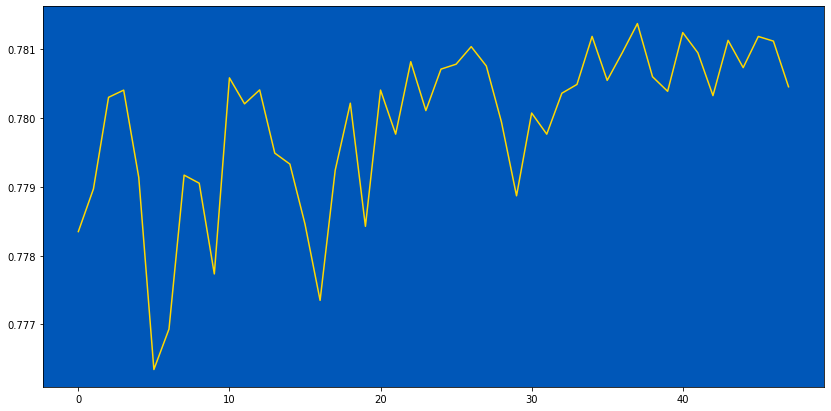

In [55]:
plt.figure(figsize=(14, 7))
trial_df.loc[trial_df["state"] == "COMPLETE"].reset_index(drop=True)["value"].plot()
plt.show()

In [57]:
trial_df.loc[trial_df["state"] == "COMPLETE"].to_csv(f"{EVALUATION_DATA_PATH}/trials/ori_lag0_dart.csv", index=False)

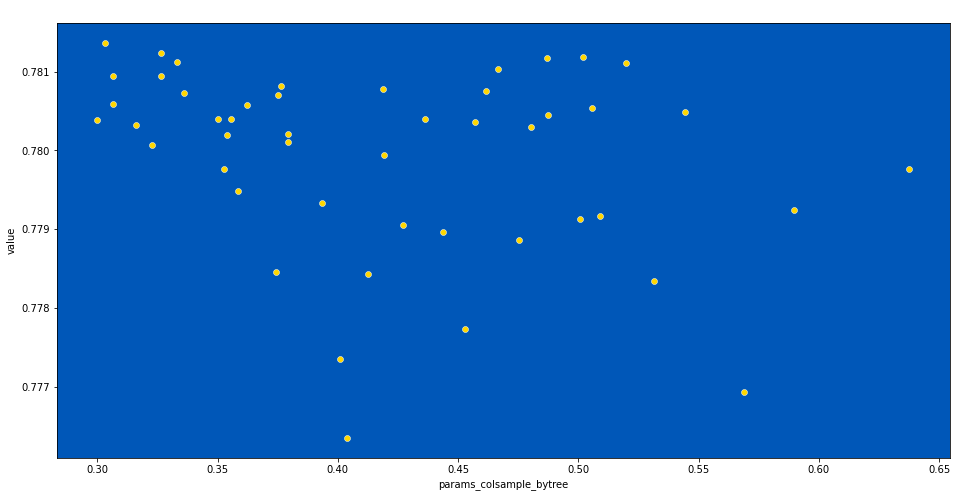

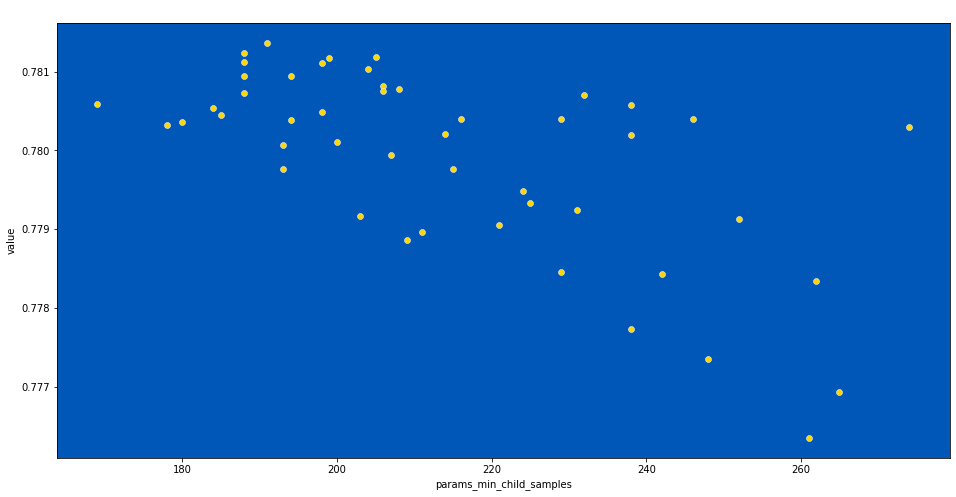

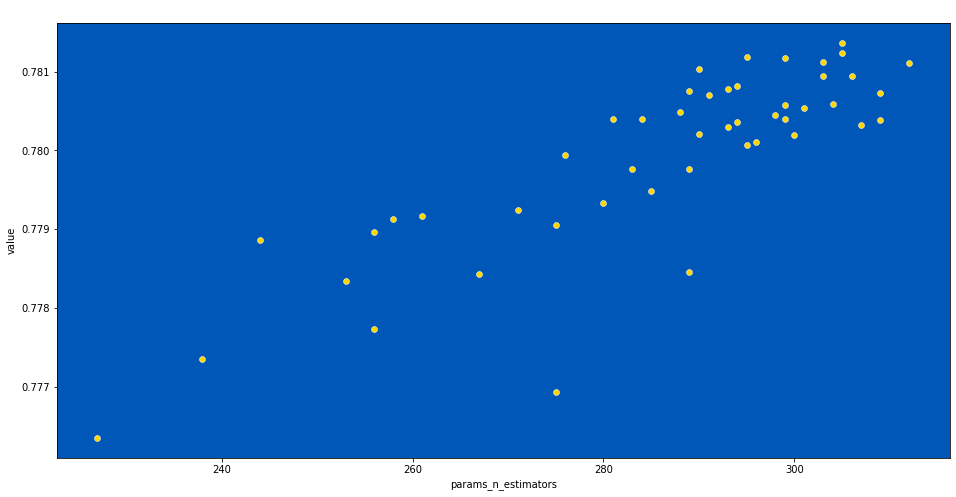

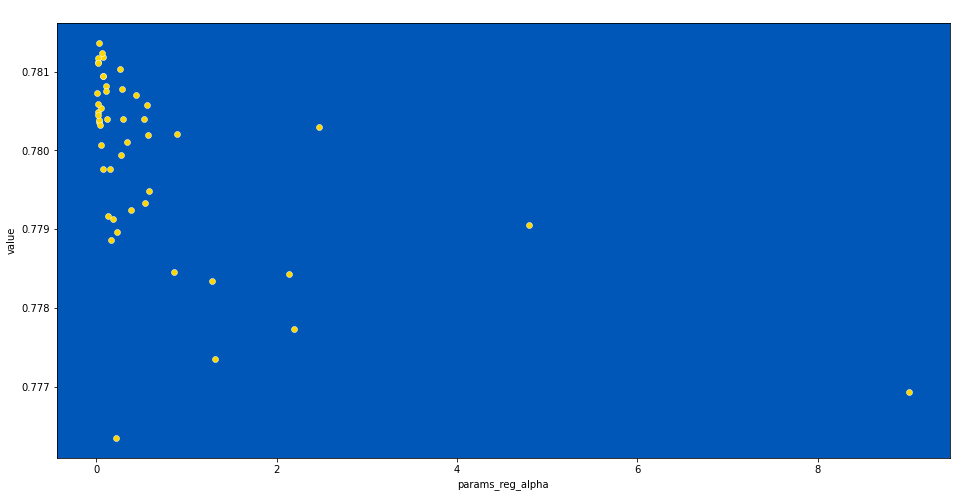

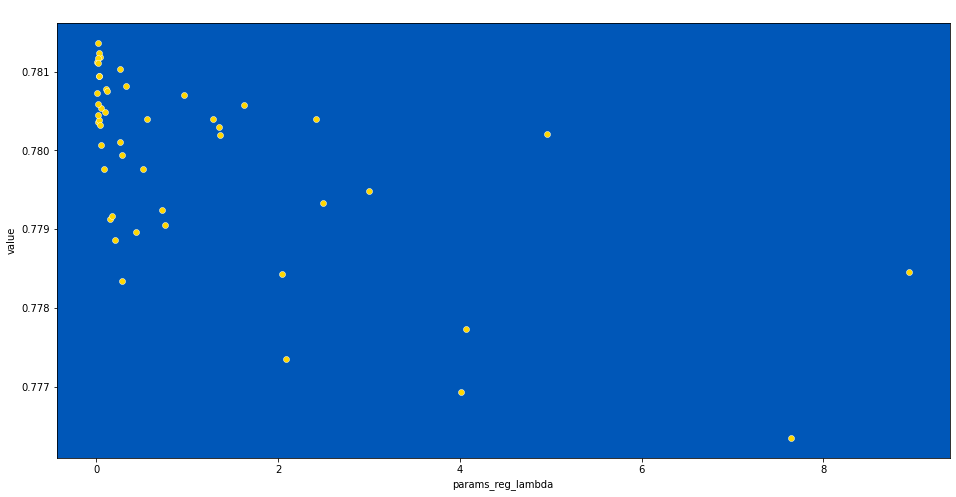

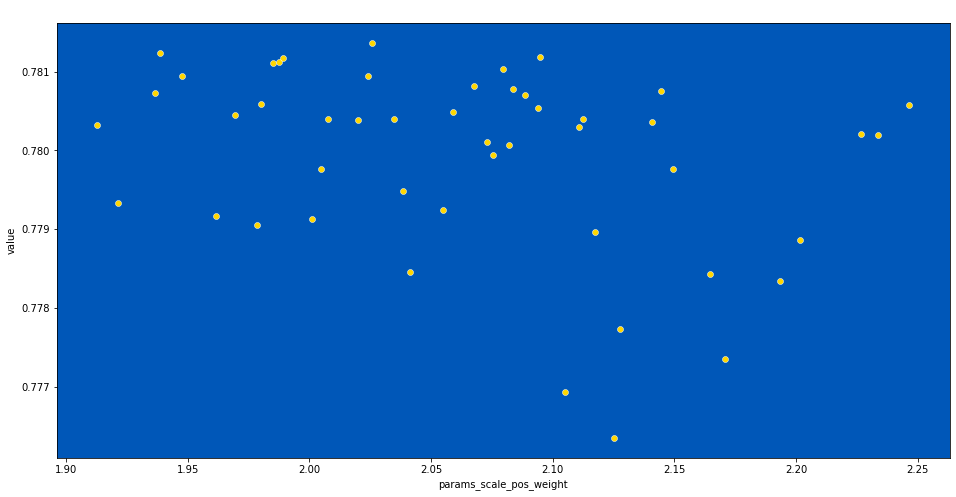

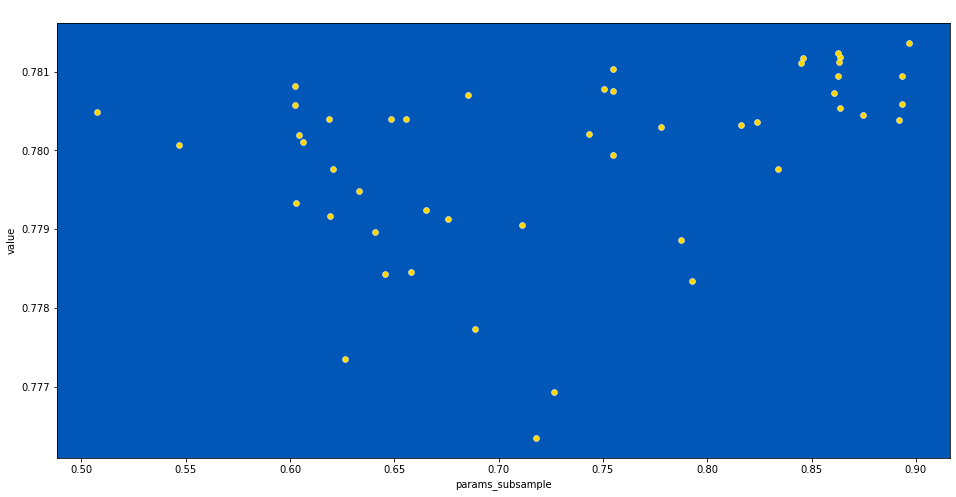

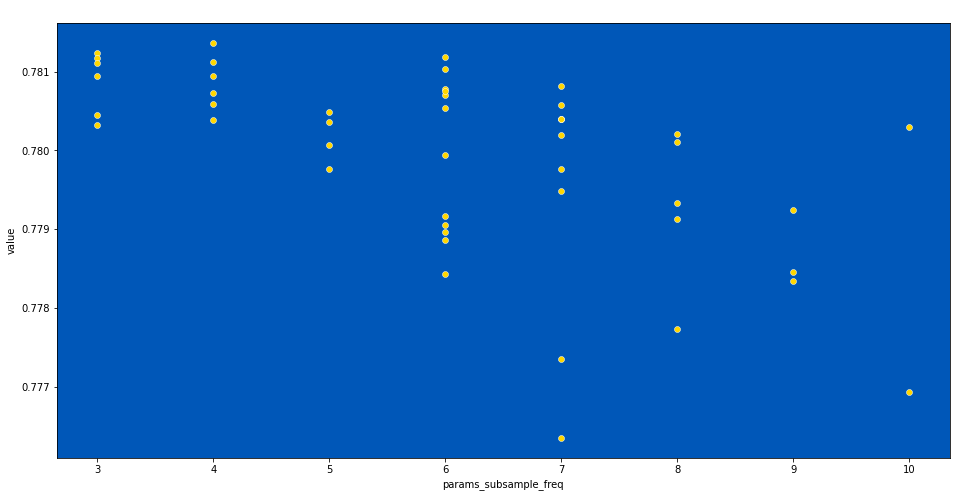

In [58]:
for col in trial_df.columns[5:-1]:
    plt.figure(figsize=(16, 8))
    sns.scatterplot(data=trial_df, x=col, y="value")
    plt.title(f"{col}")
    plt.show()

In [ ]:
params = {
    "objective": "binary",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "reg_alpha": 4.5,
    "reg_lambda": 9,
    "learning_rate": 0.05,
    "n_estimators": 195,
    "colsample_bytree": 0.6,
    "subsample": 0.7,
    "subsample_freq": 6,
    "min_child_samples": 170,
    "scale_pos_weight": 2.14,
    "max_bins": 165,
    "max_depth": 18,
}

In [ ]:
kf = StratifiedKFold(n_splits=5)
model_list, score_list = [], []
for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(train, target)):
    X_train, X_val, y_train, y_val, model = None, None, None, None, None
    X_train = train.iloc[idx_tr][features]
    X_val = train.iloc[idx_va][features]
    y_train = target[idx_tr]
    y_val = target[idx_va]
    model = LGBMClassifier(**params)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)], 
            eval_metric=[lgb_amex_metric],
            verbose=-1
            # callbacks=[log_evaluation(params["n_estimators"])]
        )
    y_train_pred = model.predict_proba(X_train, raw_score=True)
    train_score = amex_metric(y_train, y_train_pred)
    X_train, y_train = None, None
    y_val_pred = model.predict_proba(X_val, raw_score=True)
    val_score = amex_metric(y_val, y_val_pred)
    print(f"Fold {fold} | Train Score = {train_score:.5f}")
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val   Score = {val_score:.5f}{Style.RESET_ALL}")
    model_list.append(model)
    score_list.append(val_score)

In [ ]:
np.mean(score_list)

In [ ]:
raw_scores_list = []
for m in model_list:
    raw_scores = m.predict_proba(val.loc[:, features], raw_score=True)
    raw_scores_list.append(raw_scores)

In [ ]:
y_val_pred = np.array(raw_scores_list).mean(axis=0)

In [ ]:
y_val = val["target"].values

In [ ]:
amex_metric(y_val, y_val_pred)

In [ ]:
df_lag0.head()

In [ ]:
raw_scores_list = []
for m in model_list:
    raw_scores = m.predict_proba(df_lag0.loc[:, features], raw_score=True)
    raw_scores_list.append(raw_scores)

In [ ]:
y_test_pred = np.array(raw_scores_list).mean(axis=0)

In [ ]:
y_test_pred

In [ ]:
submission = pd.read_csv(f"{RAW_DATA_PATH}/sample_submission.csv")

In [ ]:
submission["prediction"] = y_test_pred

In [ ]:
# submission.to_csv(f"../submission16.csv", index=False)

In [ ]:
submission = submission.drop(columns="prediction")

In [ ]:
result = submission.merge(test_data[["customer_ID", "prediction"]], on="customer_ID")

### Copy from Kaggle

In [ ]:
mean_features = [f"{col}_mean" for col in MEAN_FEATURES]
mean_features[:3]

In [ ]:
min_features = [f"{col}_min" for col in MIN_FEATURES]
min_features[:3]

In [ ]:
max_features = [f"{col}_max" for col in MAX_FEATURES]
max_features[:3]

In [ ]:
last_features = [f"{col}_last" for col in LAST_FEATURES]
last_features[:3]

In [ ]:
ma_features = [col for col in train_data.columns if col.endswith("_ma")]
ma_features[:3]

In [ ]:
target = train_data["target"].values.astype(int)

In [ ]:
%%time
# Cross-validation of the classifier
ONLY_FIRST_FOLD = False
features = min_features + max_features + last_features + ma_features # mean_features + 
excluded_columns = ['B_30_mean', 'B_38_mean', 'D_114_mean', 'D_117_mean', 'D_120_mean', 'D_126_mean', 
                    'B_30_max', 'B_38_max', 'D_63_max', 'D_64_max', 'D_116_max', 'D_117_max', 'D_126_max',
                    'D_68_last', 'D_117_last']
features = [f for f in features if f not in excluded_columns]
print(f"{len(features)} features")

In [ ]:
def my_booster(random_state=1, n_estimators=1400):
    return LGBMClassifier(n_estimators=n_estimators,
                          learning_rate=0.03, 
                          reg_alpha=10, 
                          reg_lambda=40,
                          min_child_samples=2200,
                          num_leaves=100,
                          colsample_bytree=0.18,
                          subsample=0.85,
                          max_bins=500, 
                          scale_pos_weight=2.5,
                          random_state=1)

In [ ]:
# train[["D_63_last", "D_64_last"]] = train[["D_63_last", "D_64_last"]].astype("category")

In [ ]:
# train = train_data.copy()
# del train_data

In [ ]:
n_est_list = [2200, 1500, 2000, 1000, 1600, 1800, 1800, 1200, 1400, 1000]

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
model_dict = {}
X_val_dict = {}
y_val_dict = {}
y_score_dict = {}
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va), n_est in zip(range(1, 10+1), kf.split(train, target), n_est_list):
    model_dict[fold] = joblib.load(f"{MODELS_PATH}/lgbm_models/model_{fold}.pkl")
    X_val_dict[fold] = train.iloc[idx_va][features]
    y_val_dict[fold] = target[idx_va]
    y_score_dict[fold] = model_dict[fold].predict_proba(X_val_dict[fold], raw_score=True)

In [ ]:
for i in range(1, 11):
    print(i)
    raw_score_ = y_score_dict[i]
    target_ = y_val_dict[i]
    main_metric, gini, top4 = amex_metric_np(raw_score_, target_)
    print(f"Main metric: {main_metric:.3f}, Gini: {gini:.3f}, Top4: {top4:.3f}")
    prob_score_ = sigmoid(raw_score_)
    print(f"ROC AUC: {roc_auc_score(target_, prob_score_):.3f}")
    print(f"Average Precision: {average_precision_score(target_, prob_score_):.3f}")

In [ ]:
full_train = pd.concat(list(X_val_dict.values()))
full_train.shape

In [ ]:
full_train_gt = np.concatenate(list(y_val_dict.values()))
len(full_train_gt)

In [ ]:
full_train_scores = np.concatenate(list(y_score_dict.values()))
len(full_train_scores)

In [ ]:
full_train.loc[:, "target"] = full_train_gt
full_train.loc[:, "score"] = full_train_scores

In [ ]:
def sigmoid(log_odds):
    return 1 / (1 + np.exp(-log_odds))

In [ ]:
full_train["prob_score"] = sigmoid(full_train["score"])

In [ ]:
roc_auc_score(full_train["target"], full_train["prob_score"])

In [ ]:
# full_train.to_csv(f"{EVALUATION_DATA_PATH}/train_single_raw_score.csv", index=False)

In [ ]:
full_train = full_train.sort_values('score', ascending=False)

In [ ]:
full_train['weight'] = full_train['target'].apply(lambda x: 20 if x==0 else 1)

In [ ]:
four_pct_cutoff = int(0.04 * full_train['weight'].sum())
full_train['weight_cumsum'] = full_train['weight'].cumsum()
full_train["is_cutoff"] = 0
full_train.loc[full_train['weight_cumsum'] <= four_pct_cutoff, "is_cutoff"] = 1

In [ ]:
top_four_pct_df = full_train.loc[full_train["is_cutoff"] == 1]

In [ ]:
full_train.shape, top_four_pct_df.shape

In [ ]:
top_four_pct_df["target"].mean()

In [ ]:
full_train.describe().iloc[:, :-5].reset_index().to_csv(f"{EVALUATION_DATA_PATH}/train_description.csv", index=False)

In [ ]:
all_neg = full_train.loc[full_train["target"] == 0]
all_pos = full_train.loc[full_train["target"] == 1]

In [ ]:
wrong_top = top_four_pct_df.loc[top_four_pct_df["target"] == 0]
correct_top = top_four_pct_df.loc[top_four_pct_df["target"] == 1]

In [ ]:
wrong_top.shape, correct_top.shape

In [ ]:
col = "B_2_min"
plt.figure(figsize=(14, 8))
sns.distplot(wrong_top[col], kde=True, hist=False, label="Wrong")
sns.distplot(correct_top[col], kde=True, hist=False, label="Right")
plt.legend()
plt.show()

In [ ]:
wrong_top["B_2_min"].min(), correct_top["B_2_min"].min()

In [ ]:
rule_list = []
for col in wrong_top.columns:
    try:
        pos_minimum = all_pos[col].min()
        temp = wrong_top.loc[wrong_top[col] < pos_minimum]
        if temp.shape[0] > 0:
            # print(col, f"Minimum bound for positive class {pos_minimum}")
            rule_list.append((col, "Minimun", pos_minimum))
        pos_maximum = all_pos[col].max()
        temp = wrong_top.loc[wrong_top[col] > pos_maximum]
        if temp.shape[0] > 0:
            # print(col, f"Maximum bound for positive class {pos_maximum}")
            rule_list.append((col, "Maximum", pos_maximum))
    except:
        continue

In [ ]:
rule_df = pd.DataFrame(rule_list, columns=["feature", "type", "value"])

In [ ]:
# rule_df.to_csv(f"{EVALUATION_DATA_PATH}/rule_df.csv", index=False)

In [ ]:
correct_top.describe()

In [ ]:
full_train

In [ ]:
X = top_four_pct_df.iloc[:, :-5].select_dtypes("float").reset_index(drop=True)
y = top_four_pct_df["target"].reset_index(drop=True)

In [ ]:
# for col in X.columns:
#     if X[col].isnull().sum() > 0:
#         X[col] = X[col].fillna(X[col].mean())
#         print(col, X[col].mean())

In [ ]:
y_val_pred

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va) in zip(range(1, 10+1), kf.split(X, y)):
    X_train, X_val, y_train, y_val, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_train = X.iloc[idx_tr]
    X_val = X.iloc[idx_va]
    y_train = y[idx_tr]
    y_val = y[idx_va]
    
    model = LogisticRegression(random_state=1020)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_train, 
                  y_train)
    
    X_train, y_train = None, None
    y_val_pred = model.predict_proba(X_val)[:, 1]
    # print(precision_score(y_val, sigmoid(y_val_pred)))
    score = amex_metric(np.array(y_val), y_val_pred)
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    model_list.append(model)
    held_out_index_list.append(idx_va)
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va), n_est in zip(range(1, 10+1), kf.split(train, target), n_est_list):
    X_train, X_val, y_train, y_val, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_train = train.iloc[idx_tr][features]
    X_val = train.iloc[idx_va][features]
    y_train = target[idx_tr]
    y_val = target[idx_va]
    
    model = my_booster(n_estimators=n_est)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_train, 
                  y_train,
                  eval_set=[(X_val, y_val)], 
                  eval_metric=[lgb_amex_metric],
                  callbacks=[log_evaluation(200)])
    X_train, y_train = None, None
    y_val_pred = model.predict_proba(X_val, raw_score=True)
    score = amex_metric(y_val, y_val_pred)
    n_trees = model.best_iteration_
    if n_trees is None: 
        n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    model_list.append(model)
    held_out_index_list.append(idx_va)
    # if INFERENCE:
    #     y_pred_list.append(model.predict_proba(test[features], raw_score=True))
        
    # if ONLY_FIRST_FOLD:
    #     break # we only want the first fold
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

In [ ]:
for idx, model in enumerate(model_list):
    joblib.dump(model, f'../models/lgbm_models/model_{idx+1}.pkl')

### Train Val Split

In [ ]:
train, val = train_test_split(train_data, test_size=0.175, random_state=923, stratify=train_data["target"])

In [ ]:
train["target"].mean(), val["target"].mean()

In [ ]:
special_columns = ['customer_ID', 'S_2', 'target', "Date", "min_date", "max_date", "num_records", "days", "record_per_day"]

In [ ]:
all_cols = [c for c in train.columns if c not in special_columns]
cat_features = train.select_dtypes("category").columns.tolist()
num_features = [col for col in all_cols if col not in cat_features]

In [ ]:
len(all_cols), len(cat_features), len(num_features)

In [ ]:
cluster_columns = get_cols(train, "_cluster")
nunique_columns = get_cols(train, "_nunique")
non_D66_count_columns = [col for col in get_cols(train, "_count") if "D_66" not in col]

In [ ]:
selected_features = list(set(all_cols) - set(cluster_columns) - set(nunique_columns) - set(non_D66_count_columns))

In [ ]:
len(all_cols), len(selected_features)

In [ ]:
X_train = train.loc[:, selected_features]
X_val = val.loc[:, selected_features]

In [ ]:
y_train = train["target"]
y_val = val["target"]

In [ ]:
def _amex_metric(dy_true, dy_pred):
    """An eval metric that always returns the same value"""
    metric_name = 'Amex Metric'
    value = amex_metric_np(dy_pred, dy_true)
    is_higher_better = True
    return metric_name, value, is_higher_better

In [ ]:
fit_params = {"early_stopping_rounds" : 200, 
              # "eval_metric" : 'auc', 
              "eval_set" : [(X_val, y_val)],
              'eval_names': ['valid'],
              'verbose': 1,
              'categorical_feature': 'auto'}

In [ ]:
param_test = {'learning_rate' : [0.01, 0.03, 0.05, 0.07, 0.08, 0.1, 0.12],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(10, 150), 
              'min_child_samples': sp_randint(25, 300), 
              'min_child_weight': [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1],
              'min_split_gain': [0.001, 0.003, 0.01, 0.025, 0.05, 0.1],
              'subsample': sp_uniform(loc=0.4, scale=0.6), 
              # 'subsample_freq': [5, 10, 15],
              'max_depth': [-1, 3, 5, 7, 9, 11, 13, 15],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 3e-1, 1, 3, 6, 10, 20, 50],
              'reg_lambda': [0, 1e-1, 3e-1, 1, 3, 6, 10, 20, 50],
              'scale_pos_weight': [0, 1, 2, 3, 4],
              'xgboost_dart_mode': [True, False]
              }

# Number of combinations
n_iter = 50 

In [ ]:
# Intializing lgbm and lunching the search
lgbm_clf = LGBMClassifier(random_state=1020, 
                          objective="binary", 
                          boosting_type='dart', 
                          n_jobs=-1) # silent=True, 

In [ ]:
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, 
    param_distributions=param_test, 
    n_iter=n_iter,
    scoring=_amex_metric,
    cv=5,
    refit=True,
    random_state=923,
    verbose=True)

In [ ]:
grid_search.fit(X_train, y_train, **fit_params)
opt_parameters = grid_search.best_params_

In [ ]:
best_params = {
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.8,
    'importance_type': 'split',
    'learning_rate': 0.07,
    'max_depth': 12,
    'min_child_samples': 30,
    'min_child_weight': 0.003,
    'min_split_gain': 0.02,
    'n_estimators': 110,
    'n_jobs': -1,
    'num_leaves': 80,
    'objective': "binary",
    'random_state': 923,
    'reg_alpha': 1,
    'reg_lambda': 4,
    'silent': True,
    'subsample': 0.85,
    'subsample_for_bin': 100000,
    'subsample_freq': 5,
    'scale_pos_weight': 4
}

In [ ]:
lgbm_clf = LGBMClassifier(**best_params)

In [ ]:
lgbm_clf.fit(X_train, y_train)

In [ ]:
y_train_pred = lgbm_clf.predict_proba(X_train)[:, 1]
y_val_pred = lgbm_clf.predict_proba(X_val)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred, y_val_pred], 
                labels=["Train", "Validation"], 
                title="Train Validation ROC AUC")

In [ ]:
imp_df = plot_feature_importance(lgbm_clf.feature_name_, 
                                 lgbm_clf.feature_importances_, 
                                 title="Feature Importance",
                                 limit=50)

In [ ]:
result = pd.DataFrame()
for keyword in ["_mean", "std", "min", "max", "first", "last", "count"]:
    temp = imp_df.loc[imp_df["feature"].str.contains(keyword)].describe().rename(columns={"feature_importance": keyword})
    result = pd.concat([result, temp], axis=1)

In [ ]:
result

In [ ]:
cluster_feature_imp_df = imp_df.loc[imp_df["feature"].str.contains("count")]

In [ ]:
cluster_result = pd.DataFrame()
for keyword in ["B_", "S_", "R_", "P_", "D_"]:
    temp = cluster_feature_imp_df.loc[cluster_feature_imp_df["feature"].str.contains(keyword)].describe().rename(columns={
        "feature_importance": keyword
    })
    cluster_result = pd.concat([cluster_result, temp], axis=1)

In [ ]:
imp_df.shape[0], result.loc["count"].sum()

### Test Metric

In [ ]:
y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
y_val_pred_df = pd.DataFrame(y_val_pred).rename(columns={0: "prediction"})

In [ ]:
# feature_imp_thr = imp_df.loc[imp_df["feature"] == "dummy"]["feature_importance"].values[0]
# feature_imp_thr

In [ ]:
selected_features = imp_df.loc[imp_df["feature_importance"] > 0]["feature"].tolist()
len(selected_features)

### Train once

In [ ]:
best_params = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.7,
 'importance_type': 'split',
 'learning_rate': 0.07,
 'max_depth': 7,
 'min_child_samples': 50,
 'min_child_weight': 0.05,
 'min_split_gain': 0.04,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 80,
 'objective': None,
 'random_state': 1020,
 'reg_alpha': 5,
 'reg_lambda': 15,
 'silent': True,
 'subsample': 0.7,
 'subsample_for_bin': 20000,
 'subsample_freq': 5,
 'scale_pos_weight': 1}

In [ ]:
final_lgbm_clf = LGBMClassifier(**best_params)

In [ ]:
final_lgbm_clf.fit(X_train, y_train)

In [ ]:
y_train_pred = final_lgbm_clf.predict_proba(X_train)[:, 1]
y_val_pred = final_lgbm_clf.predict_proba(X_val)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred, y_val_pred], 
                labels=["Train", "Validation"], 
                title="Train Validation ROC AUC")

In [ ]:
imp_df = plot_feature_importance(final_lgbm_clf.feature_name_, 
                                 final_lgbm_clf.feature_importances_, 
                                 title="Feature Importance",
                                 limit=50)

In [ ]:
# feature_imp_thr = imp_df.loc[imp_df["feature"] == "dummy"]["feature_importance"].values[0]
# feature_imp_thr

In [ ]:
selected_features = imp_df.loc[imp_df["feature_importance"] > 0]["feature"].tolist()
len(selected_features)

#### Final x2 LGBM

In [ ]:
selected_features = [col for col in selected_features if "first" not in col]
len(selected_features)

In [ ]:
final_lgbm_clf = LGBMClassifier(**best_params)

In [ ]:
X_train_ = X_train.loc[:, selected_features]
X_val_ = X_val.loc[:, selected_features]

In [ ]:
final_lgbm_clf.fit(X_train_, y_train)

In [ ]:
y_train_pred_ = final_lgbm_clf.predict_proba(X_train_)[:, 1]
y_val_pred_ = final_lgbm_clf.predict_proba(X_val_)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred_, y_val_pred_], 
                labels=["Train", "Validation"], 
                title="Train Validation ROC AUC")

In [ ]:
y_res_df = pd.DataFrame(y_res).reset_index(drop=True)
y_res_pred_df = pd.DataFrame(y_res_pred_).rename(columns={0: "prediction"})

In [ ]:
amex_metric(y_res_df, y_res_pred_df)

In [ ]:
y_val.values[:40]

In [ ]:
temp_ = [1 if c > 0.95 else c for c in y_val_pred_]
# temp_[:40]

In [ ]:
y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
y_val_pred_df = pd.DataFrame(y_val_pred_).rename(columns={0: "prediction"})

In [ ]:
amex_metric(y_val_df, y_val_pred_df)

### END

### LGBM Model

In [ ]:
opt = BayesSearchCV(
    LGBMClassifier(random_state=1020),
    {
        'learning_rate': (0.04, 0.1),
        'num_leaves': (31, 127),
        'max_depth': (5, 20),
        'min_child_samples': (15, 63),
        'n_estimators': (80, 160),
        'subsample': (0.7, 0.9),
        'subsample_freq': (2, 5),
        'colsample_bytree': (0.6, 0.95),
        'reg_alpha': (0, 15),
        'reg_lambda': (0, 15),
        'min_split_gain': (0, 0.05),
        'scale_pos_weight': (0.1, 10)
    },
    n_iter=5,
    cv=5,
    scoring=make_scorer(fbeta_score, beta=2)
)

In [ ]:
start = time.time()
opt.fit(X_train, y_train, verbose=1)
end = time.time()
print(f"Done in {end - start:.2f} seconds")

In [ ]:
best_params = opt.best_estimator_.get_params()

In [ ]:
best_params

In [ ]:
imp_df = plot_feature_importance(final_lgbm_clf.feature_name_, 
                                 final_lgbm_clf.feature_importances_, 
                                 title="Feature Importance",
                                 limit=50)

In [ ]:
num_features_list, train_score_list, val_score_list = [], [], []
for imp_value in tqdm(sorted(imp_df["feature_importance"].unique())):
    selected_features = imp_df.loc[imp_df["feature_importance"] > imp_value]["feature"].tolist()
    print(f"# of features: {len(selected_features)}")
    
    X_train_new = train.loc[:, selected_features]
    X_val_new = val.loc[:, selected_features]
    
    lgbm_clf = LGBMClassifier(**params)
    lgbm_clf.fit(X_train_new, y_train)
    
    y_train_pred = lgbm_clf.predict_proba(X_train_new)[:, 1]
    y_val_pred = lgbm_clf.predict_proba(X_val_new)[:, 1]
    
    y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
    y_train_pred_df = pd.DataFrame(y_train_pred).rename(columns={0: "prediction"})
    y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
    y_val_pred_df = pd.DataFrame(y_val_pred).rename(columns={0: "prediction"})
    
    train_score = amex_metric(y_train_df, y_train_pred_df)
    val_score = amex_metric(y_val_df, y_val_pred_df)
    num_features_list.append(len(selected_features))
    train_score_list.append(train_score)
    val_score_list.append(val_score)

In [ ]:
train_scores = [i[0] for i in train_score_list]
val_scores = [i[0] for i in val_score_list]

In [ ]:
eval_df = pd.DataFrame(dict(num_feature=num_features_list, 
                            train_score=train_scores, 
                            val_score=val_scores)).iloc[:-10]

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(eval_df["num_feature"], eval_df["train_score"], label="Train")
plt.plot(eval_df["num_feature"], eval_df["val_score"], label="Validation")
plt.legend()
plt.show()

### LGBM Error Analysis

In [ ]:
X_validation = X_val_.reset_index(drop=True)

In [ ]:
top4_pct_df, gini_df = get_final_metric_df(X_validation, y_val_df, y_val_pred_df)

In [ ]:
failed_top4_pct_indices = top4_pct_df.loc[(top4_pct_df["is_cutoff"] == 1) & (top4_pct_df["target"] == 0)].index

In [ ]:
# failed_top4_pct_indices

In [ ]:
failed_top4_pct_indices

In [ ]:
success_top4 = top4_pct_df.loc[~top4_pct_df.index.isin(failed_top4_pct_indices)]
failed_top4 = top4_pct_df.loc[failed_top4_pct_indices]

In [ ]:
success_top4.shape, failed_top4.shape

In [ ]:
column = "P_2_last"

In [ ]:
top4_pct_df.groupby("target")[column].mean()

In [ ]:
success_top4[column].describe()

In [ ]:
failed_top4[column].describe()

In [ ]:
# save model
# joblib.dump(final_lgbm_clf, '../models/lgbm_version1.pkl')

In [ ]:
# load model
loaded_lgbm_model = joblib.load('../models/lgbm_version1.pkl')

### SMOTE

In [ ]:
train.loc[:, num_features] = train.loc[:, num_features].fillna(0)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=923)
X_res, y_res = sm.fit_resample(train.loc[:, num_features], 
                               train["target"])

In [ ]:
X_res.shape, y_res.shape

### Inference

In [ ]:
X_test = test_data.loc[:, selected_features]

In [ ]:
y_test_pred = loaded_lgbm_model.predict_proba(X_test)[:, 1]

In [ ]:
test_data["prediction"] = y_test_pred

In [ ]:
test_data.head()

#### Submission

In [ ]:
submission = pd.read_csv(f"{DATA_PATH}/sample_submission.csv")

In [ ]:
submission = submission.drop(columns="prediction")

In [ ]:
result = submission.merge(test_data[["customer_ID", "prediction"]], on="customer_ID")

In [ ]:
# result.to_csv(f"{SUBMISSION_DATA_PATH}/submission4.csv", index=False)

#### Convert Data to Integer Type

In [ ]:
# for i in range(1, 11):
#     # df = read_file(f"{RAW_TRAIN_PICKLE_PATH}/train_data_{i}.pkl")
#     # df = read_file(f"{RAW_TEST_PICKLE_PATH}/test_data_{i}.pkl")
#     print(df.shape)
#     for int_col in INTEGER_COLUMNS:
#         print(f"{df[int_col].isnull().sum()} cells will be imputed")
#         df.loc[df[int_col].isnull(), int_col] = df.loc[df[int_col].isnull(), int_col].fillna(df[int_col].mean())
#         if df[int_col].isnull().sum() > 100:
#             print("Too many missing values")
#             sys.exit()
#         df[int_col] = df[int_col].round().astype(np.int8)
#     # df.to_pickle(f"{RAW_TRAIN_PICKLE_PATH}/train_data_{i}.pkl")
#     # df.to_pickle(f"{RAW_TEST_PICKLE_PATH}/test_data_{i}.pkl")
#     print(f"Test {i} done")

### Imputation using KNN + Correlation

In [ ]:
corr_df = df.iloc[:, 3:-1].corr()

In [ ]:
null_count_df = df.iloc[:, 3:-1].isnull().sum().sort_values()

In [ ]:
potential_to_impute_columns = null_count_df[(null_count_df > 0) & (null_count_df < df.shape[0] * 0.2)].index.tolist()
potential_to_impute_null_counts = null_count_df[(null_count_df > 0) & (null_count_df < df.shape[0] * 0.2)].values.tolist()

In [ ]:
impute_col_index = 0

In [ ]:
target_impute_column = potential_to_impute_columns[impute_col_index]
target_impute_column

In [ ]:
target_impute_null_count = potential_to_impute_null_counts[impute_col_index]
target_impute_null_count

In [ ]:
high_corr_df = corr_df.loc[
    ~corr_df[target_impute_column].between(-0.4, 0.4) & ~corr_df[target_impute_column].isnull(),
    target_impute_column
]
high_corr_df = high_corr_df.abs().sort_values(ascending=False)
high_corr_df

In [ ]:
potential_features = high_corr_df.index.tolist()
potential_features.remove(target_impute_column)
print(potential_features)

In [ ]:
potential_features_null_count = df.loc[:, potential_features].isnull().sum()
potential_features = potential_features_null_count[potential_features_null_count == 0].index.tolist()
if len(potential_features) > 10:
    potential_features = potential_features[:10]
potential_features

In [ ]:
if len(potential_features) > 0:
    temp = df.loc[df[target_impute_column].isnull(), potential_features + [target_impute_column]]
    print(f"{len(potential_features)} potential feature(s), showing the target column against the first feature")
    sns.scatterplot(data=df, 
                    x=potential_features[0], 
                    y=target_impute_column)
    plt.show()
else:
    temp = df.loc[df[target_impute_column].isnull(), ["customer_ID", "row_number", target_impute_column]]
    print("No potential features, proceed with mean imputation")
    df.loc[df[target_impute_column].isnull(), target_impute_column] = df[target_impute_column].mean()
    print(f"Imputed {len(temp.index)} rows of data")

In [ ]:
# df[target_impute_column].plot.box()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
all_data = df.loc[:, ["customer_ID"] + potential_features + [target_impute_column]]

In [ ]:
train_val = all_data.loc[~all_data[target_impute_column].isnull()]
test = all_data.loc[all_data[target_impute_column].isnull()]

In [ ]:
train, val = train_test_split(train_val, test_size=0.2, random_state=1)

In [ ]:
test

In [ ]:
train.shape, val.shape, test.shape

In [ ]:
X_train = train.loc[:, potential_features]
X_val = val.loc[:, potential_features]
X_test = test.loc[:, potential_features]
y_train = train[target_impute_column]
y_val = val[target_impute_column]
y_test = test[target_impute_column]

In [ ]:
%%time
min_mse = np.inf
for k in [3, 5, 9, 13]:
    knn_model = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)
    y_val_pred = knn_model.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    if mse < min_mse:
        min_mse = mse
        best_knn_model = knn_model
        print(f"K: {k}, Validation MSE: {min_mse:.6f}")

In [ ]:
y_test

In [ ]:
df.loc[y_test.index, target_impute_column] = knn_model.predict(X_test)

In [ ]:
df.loc[y_test.index, target_impute_column]